# Fixture Modelling

How many goals are PL teams to score and concede in upcoming fixtures?

See here for some more technical details http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf

## Setup

In [1]:
import pandas as pd
from datetime import timezone
import numpy as np
import scipy.stats
import scipy.optimize
import seaborn as sns

In [2]:
from src.utils.elo import Elo

In [4]:
!cd data/Fantasy-Premier-League && git pull # pull latest data

Already up to date.


## Load data

In [5]:
SEASONS = ['2018-19' ,'2019-20','2020-21', '2021-22',]

In [6]:
BASE = 'data/Fantasy-Premier-League'

In [7]:
combined = pd.DataFrame()
for season in SEASONS:
    df = pd.read_csv(f'{BASE}/data/{season}/fixtures.csv',parse_dates=['kickoff_time'])
    df['season'] = season
    combined = df.append(combined)

In [8]:
teams = pd.read_csv(f'{BASE}/data/master_team_list.csv')

the numbers aren't consistent across seasons so we merge on names and come up with our own numbering

In [9]:
def clean_names(combined, teams):    
    with_names = combined.copy()
    for suff in ['_h','_a']:
        with_names = with_names.merge(teams.rename(columns={'team':f"team{suff}",
                                                            "team_name":f'team_name{suff}'}),on = ['season',f'team{suff}'],how='left')
    unique_teams = list(set(with_names["team_name_h"]))
    name_mapping = dict(zip(unique_teams,range(len(unique_teams))))
    with_names['team_h'] = with_names.team_name_h.map(name_mapping) 
    with_names['team_a'] = with_names.team_name_a.map(name_mapping)
    with_names['days_since_fixture'] = (pd.Timestamp.utcnow() - with_names['kickoff_time']).dt.days
    return with_names, name_mapping

In [10]:
df, name_mapping = clean_names(combined, teams)

In [11]:
COLS = ['team_h','team_a','days_since_fixture','team_h_score','team_a_score']

In [12]:
results = df.loc[(df.finished),COLS].copy()
fixtures = df.loc[~df.finished,COLS].copy() 

In [13]:
assert df['team_name_h'].isna().sum() == 0

## Fit model - (1) Dixon-Coles like

We model a game with home/away score (x,y) as being

$\lambda_h = exp(\mu + \gamma + \alpha_{ha} - \alpha_{ad})$

$\lambda_a = exp(\gamma + \alpha_{aa} - \alpha_{hd})$

$p(x,y) = \frac{exp(-\lambda_h)(\lambda_h)^x}{x!} \frac{exp(-\lambda_a)(\lambda_a)^y}{y!}$

Each team has a coefficient for attacking/defending, and there is a fixed effect $\gamma$ and a home-team fixed effect $\mu$. 

In [14]:
def neg_log_likehihood(params, df, discount, n_teams):
    '''
    Based on model above, sum the negative log likelihood, discounted by time
    '''
    mu, gamma, *alpha  = params
    alpha_score = alpha[:n_teams]
    alpha_concede = alpha[n_teams:]
    home = mu +gamma + np.take(alpha_score,df.team_h) - np.take(alpha_concede,df.team_a)
    away = gamma + np.take(alpha_score,df.team_a) - np.take(alpha_concede,df.team_h)
    exp_home = np.exp(home)
    exp_away = np.exp(away)
    neg_log_lik = exp_home - (df["team_h_score"] * home) + exp_away - (df["team_a_score"] * away)
    loss = (np.exp(-discount * df["days_since_fixture"]) * neg_log_lik).sum()
    return loss / df.shape[0]

In [15]:
class DixonColes():
    def __init__(self, name_mapping, discount = 0.01):
        self.name_mapping = name_mapping
        self.n_teams = len(name_mapping)
        self.discount = discount 
        self.params = [0.0 for _ in range(2 + (2*self.n_teams))]
    
    def fit(self, X): 
        '''
        Minimise negative log-likelihood
        '''
        res = scipy.optimize.minimize(
            fun=neg_log_likehihood,
            x0=self.params,
            args=(X, self.discount, self.n_teams),
        )
        mu, gamma, *alpha = res['x']
        alpha_score = alpha[:self.n_teams]
        alpha_concede = alpha[self.n_teams:]
        return mu, gamma, alpha_score, alpha_concede
        


In [16]:
mu, gamma, alpha_score, alpha_concede =  DixonColes(name_mapping).fit(results)

In [17]:
mu

0.07830215230703062

In [18]:
form = pd.DataFrame(data=[name_mapping.keys(),alpha_score, alpha_concede]).T
form.columns = ['team', 'attack','defence']

In [19]:
form['total'] = form.attack + form.defence

This seams like a reasonable form ranking. I think the model is overrating Brentford a bit having never seen them before.

In [20]:
(form
 .iloc[list(set(fixtures.team_h))]
 .sort_values(by='total',ascending=False))

,team,attack,defence,total
24,Chelsea,0.678827,0.942345,1.62117
17,Man City,0.710605,0.753318,1.46392
21,Liverpool,0.833183,0.584161,1.41734
12,Brentford,0.201776,0.364181,0.565957
0,West Ham,0.264842,0.186588,0.45143
2,Arsenal,0.215224,0.0754985,0.290722
5,Leicester,0.468689,-0.231372,0.237317
15,Man Utd,0.343715,-0.140456,0.203259
18,Spurs,0.134176,-0.0260193,0.108157
9,Aston Villa,0.16996,-0.132336,0.0376244


## Fit Model (2) - ELO

In [21]:
results['outcome'] =(np.clip(results['team_h_score'] -results['team_a_score'],-1,1) + 1) / 2

In [22]:
results = results.sort_values(by='days_since_fixture',ascending=False)

In [23]:
elo =Elo(results,k_factor=35)
historic_elo, elo_ratings =elo.process_all_fixtures()

## Plot elo over time

In [24]:
inv_mapping = {v:k for k,v in name_mapping.items()}

In [25]:
historic_elo['name'] = historic_elo.team_h.map(inv_mapping)

In [26]:
historic_elo['neg_days_since_fixture'] = historic_elo['days_since_fixture'] * -1

In [27]:
filtered = historic_elo.loc[historic_elo.name.isin(['Chelsea', 'Man City', 'Liverpool','West Ham', 'Man Utd'])]

<AxesSubplot:xlabel='neg_days_since_fixture', ylabel='elo'>

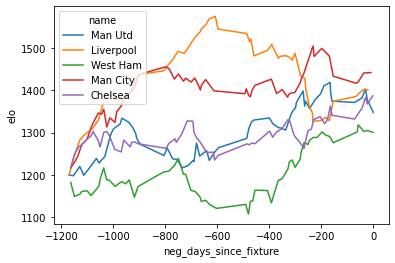

In [28]:
sns.lineplot(data=filtered, hue='name', y='elo', x='neg_days_since_fixture')

In [29]:
form['elo'] =pd.Series(elo_ratings).sort_index()

In [30]:
form.iloc[list(set(fixtures.team_h))].sort_values(by='total',ascending=False)


,team,attack,defence,total,elo
24,Chelsea,0.678827,0.942345,1.62117,1389.799867
17,Man City,0.710605,0.753318,1.46392,1453.959042
21,Liverpool,0.833183,0.584161,1.41734,1422.617327
12,Brentford,0.201776,0.364181,0.565957,1219.239164
0,West Ham,0.264842,0.186588,0.45143,1317.315888
2,Arsenal,0.215224,0.0754985,0.290722,1307.088361
5,Leicester,0.468689,-0.231372,0.237317,1275.638134
15,Man Utd,0.343715,-0.140456,0.203259,1333.342874
18,Spurs,0.134176,-0.0260193,0.108157,1273.754757
9,Aston Villa,0.16996,-0.132336,0.0376244,1205.220780


## Map form onto fixtures

In [38]:
CURRENT_GAMEWEEK = 9 # I should probably calculate this from fixtures

map on the expected scoring rates

In [39]:
fixtures['score'] = np.exp(mu +gamma + np.take(alpha_score,fixtures.team_h) - np.take(alpha_concede,fixtures.team_a))
fixtures['opp_score'] = np.exp(gamma + np.take(alpha_score,fixtures.team_a) - np.take(alpha_concede,fixtures.team_h))

In [40]:
fixtures['elo_win'] =fixtures.apply(lambda row: elo.win_prob(row['team_h'],row['team_a']),axis=1)

In [41]:
fixtures['team'] = fixtures['team_h'].map(inv_mapping)
fixtures['opp'] = fixtures['team_a'].map(inv_mapping)

We flip home and away fixtures to have all fixtures for all teams in long format

In [42]:
upcoming_difficulties = fixtures[['team','opp','score','elo_win','opp_score','days_since_fixture']]

In [43]:
flipped_difficulties = upcoming_difficulties.copy().rename(columns={'team':'opp',
                                                                    'opp':'team',
                                                                    'score':'opp_score',
                                                                    'opp_score':'score',})
flipped_difficulties['elo_win'] = 1 -flipped_difficulties['elo_win']

In [44]:
assert (upcoming_difficulties.groupby('team')['opp'].count() + upcoming_difficulties.groupby('opp')['team'].count()).max() == 38 - CURRENT_GAMEWEEK

In [45]:
combined_difficulties = upcoming_difficulties.append(flipped_difficulties)

In [46]:
combined_difficulties['gw'] = combined_difficulties.reset_index().sort_values(by='days_since_fixture').groupby('team').days_since_fixture.cumcount() +1 + CURRENT_GAMEWEEK

In [47]:
score_pivot = pd.pivot_table(data=combined_difficulties,values='score',
                             index='team',columns='gw')

In [48]:
defend_pivot = pd.pivot_table(data=combined_difficulties,values='opp_score',
                              index='team',columns='gw')

In [49]:
elo_pivot = pd.pivot_table(data=combined_difficulties,values='elo_win',
                              index='team',columns='gw')

Filter the data for the next n weeks

In [50]:
N = 5

In [51]:
for outcome in ['score','opp_score','elo_win']:
    print(outcome)
    pivot = pd.pivot_table(data=combined_difficulties,values=outcome,
                             index='team',columns='gw')
    n_week = pivot.iloc[:,:N].copy()
    n_week['avg'] = n_week.mean(axis=1)
    sort_dir = outcome == 'opp_score'
    display(n_week
     .sort_values(by='avg',ascending=sort_dir) 
     .style.background_gradient(cmap='Blues'))

score


gw,10,11,12,13,14,avg
team,,,,,,
Man City,2.422798,2.804779,2.884497,2.501494,3.638309,2.850375
Liverpool,2.098844,2.286125,2.362324,4.447754,2.986381,2.836286
Chelsea,3.534778,2.559230,2.975652,2.347017,2.189323,2.721200
Brentford,1.717651,2.187349,2.193722,1.256386,1.575223,1.786066
Man Utd,1.733251,0.735180,2.688505,1.676955,1.799884,1.726755
West Ham,1.781476,0.804642,1.366501,2.336527,1.818799,1.621589
Aston Villa,1.089081,1.512807,1.081301,2.259696,1.964980,1.581573
Leicester,1.640748,2.054958,0.689565,1.549293,1.587824,1.504478
Southampton,1.684278,1.116686,1.707933,1.354071,1.125790,1.397752


opp_score


gw,10,11,12,13,14,avg
team,,,,,,
Chelsea,0.461146,0.348778,0.689565,0.503961,0.535176,0.507725
Man City,0.608822,0.735180,0.581084,0.596200,0.103655,0.524988
Liverpool,0.517271,0.804642,0.828057,0.113513,0.499007,0.552498
Brentford,0.574959,0.152964,0.822113,1.031802,0.830776,0.682523
Brighton,2.098844,1.054270,1.081301,0.681790,1.130939,1.209429
Southampton,1.352894,1.512807,0.216984,1.216403,1.799884,1.219794
Wolves,1.080696,1.047005,1.366501,1.549293,1.199120,1.248523
Leeds,0.218630,2.054958,1.359940,1.676955,1.325460,1.327189
West Ham,1.089081,2.286125,0.758413,0.981882,1.587824,1.340665


elo_win


gw,10,11,12,13,14,avg
team,,,,,,
Man City,0.825646,0.666928,0.786144,0.738336,0.936605,0.790732
Liverpool,0.760125,0.647065,0.660391,0.925011,0.858903,0.770299
Chelsea,0.807155,0.834422,0.658624,0.765980,0.616833,0.736603
Man Utd,0.584923,0.333072,0.772559,0.651181,0.731846,0.614716
Brentford,0.653728,0.792773,0.610593,0.376202,0.550804,0.596820
West Ham,0.655944,0.352935,0.659182,0.733876,0.559693,0.592326
Brighton,0.239875,0.614716,0.524498,0.657651,0.641840,0.535716
Arsenal,0.545137,0.744918,0.339609,0.623798,0.383167,0.527326
Aston Villa,0.344056,0.566228,0.475502,0.618996,0.591244,0.519205
